<a href="https://colab.research.google.com/github/siddhu1716/IIIT_Hyderabad_Python/blob/main/AIML_Module_1_Lab_3_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [ ]:
# !pip3 install scikit-image

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
# print(rng)
import sklearn
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math


Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [ ]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [ ]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255
print(train_X.shape)
train_X = train_X[::1200].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels
print(train_X.shape)

(60000, 28, 28)
(50, 28, 28)


Let us borrow a few functions from the previous labs:

In [ ]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  # print(diff)
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  # print(dist)
  # print(np.argmin(dist))
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  # print(traindata[0].shape)
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  # print(traindata[0])
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  # print(traindata.shape)
  # temp = (NN1(traindata, trainlabel, testdata[0]))
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [ ]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

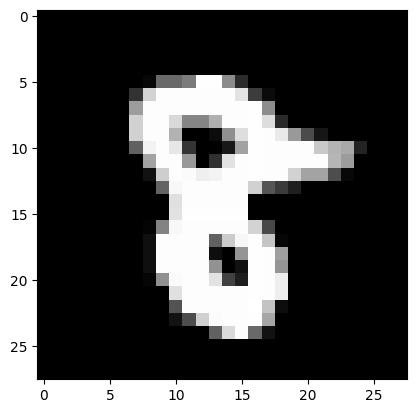

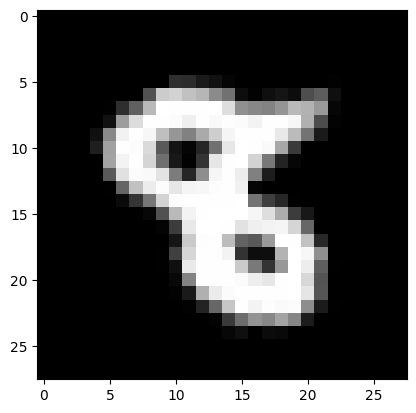

In [ ]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [ ]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

In [ ]:
train_X[20]

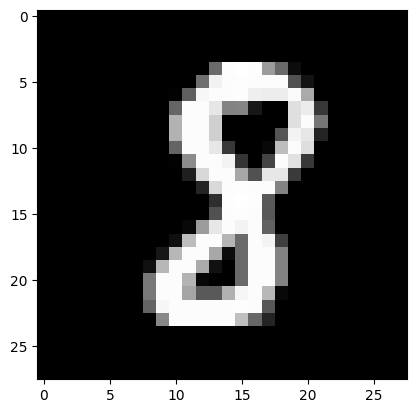

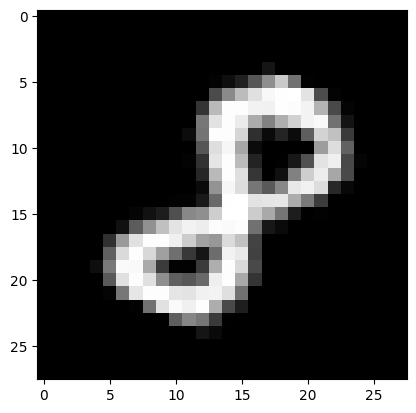

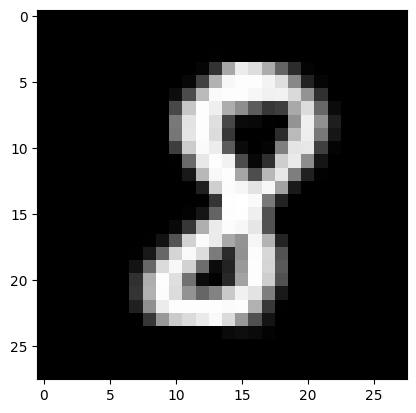

In [ ]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.show()
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.show()


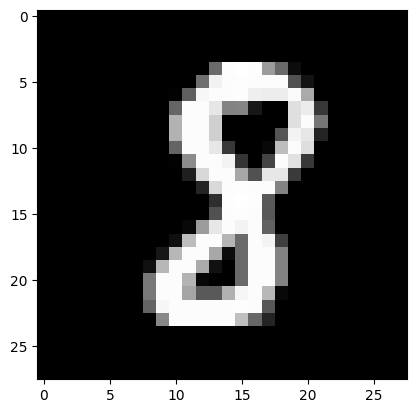

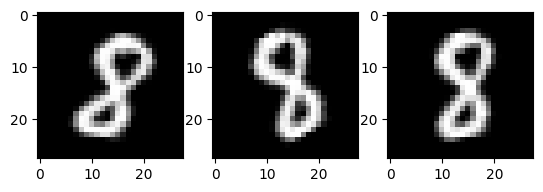

In [ ]:
sample = train_X[20]
angleconstraint = 70#maximum angle which the image can be rotated
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60 #maximum rotatio of image
naugmentations = 5 #how mant times you want to rotate the image

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.663


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [ ]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints),dtype=np.float64) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6626
Accuracy after rotation augmentation constrained by  20  is  0.6863
Accuracy after rotation augmentation constrained by  30  is  0.6727
Accuracy after rotation augmentation constrained by  40  is  0.6754
Accuracy after rotation augmentation constrained by  50  is  0.6728
Accuracy after rotation augmentation constrained by  60  is  0.6631
Accuracy after rotation augmentation constrained by  70  is  0.6674
Accuracy after rotation augmentation constrained by  80  is  0.6687
Accuracy after rotation augmentation constrained by  90  is  0.6335


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

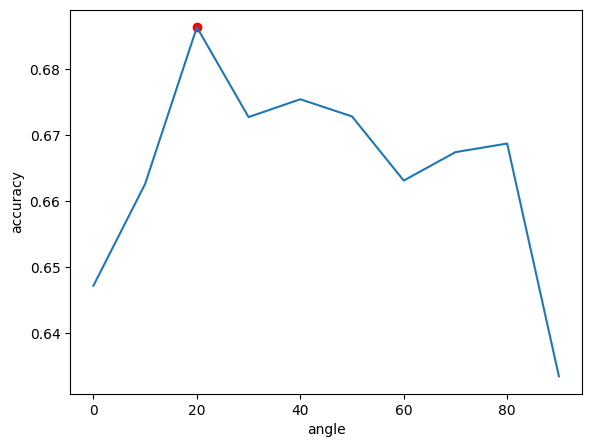

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [ ]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

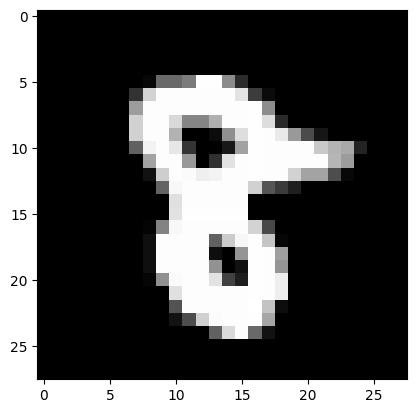

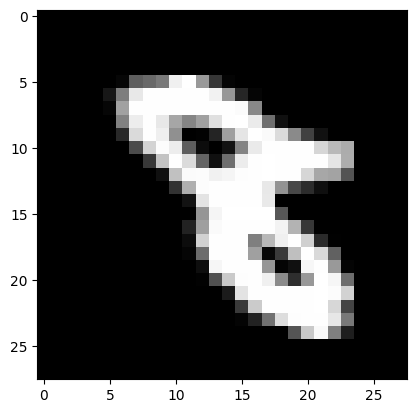

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float64) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.632
Accuracy after shear augmentation constrained by  0.4  is  0.643
Accuracy after shear augmentation constrained by  0.6  is  0.6508
Accuracy after shear augmentation constrained by  0.8  is  0.6608
Accuracy after shear augmentation constrained by  1.0  is  0.6665
Accuracy after shear augmentation constrained by  1.2  is  0.6443
Accuracy after shear augmentation constrained by  1.4  is  0.6557
Accuracy after shear augmentation constrained by  1.6  is  0.6378
Accuracy after shear augmentation constrained by  1.8  is  0.6374
Accuracy after shear augmentation constrained by  2.0  is  0.6373


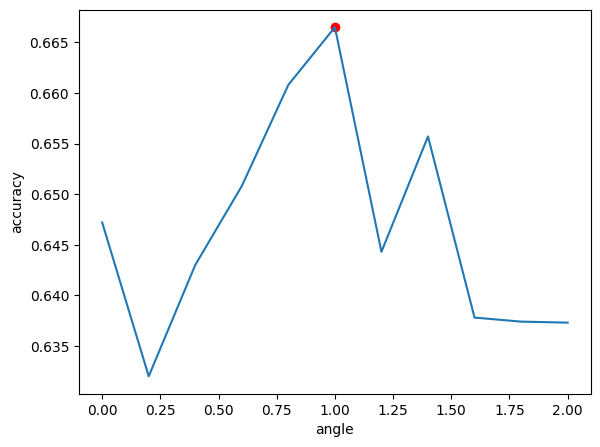

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test

hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float64) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6227
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6179
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6099
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6055
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6086
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6254
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6337
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6215
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6325
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6168
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6323
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.6305
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6206
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6342
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

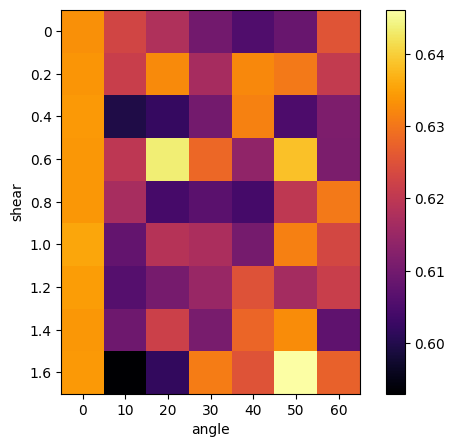

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

Answers:

1.The combination of shearconstraint = 1.6 and angleconstraint = 50.0 results in the highest accuracy, which is approximately 0.6461. for the above dataset, the best values for the angle constraint and shear constraint will depend on your specific dataset and task , 0.6472 is the accuracy for not using augumentation, the accuracy decreased by 0.0011

2.It will eventually increase the accuracy when you are having less data , but we cannot predict its outputs Increasing the number of augmentations from each sample can potentially improve the accuracy of your model up to a certain point. Augmentations are intended to enhance the model's ability to generalize by exposing it to variations in the training data.

In [ ]:
3. #blur the image
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
% matplotlib inline
sample=train_X[2]
blurred = gaussian(sample,sigma=1,multichannel=True)
plt.imshow(blurred)


UsageError: Line magic function `%` not found.


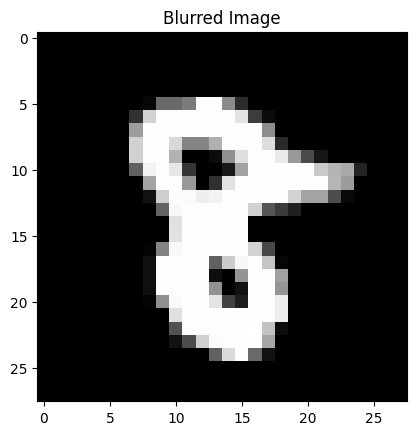

In [ ]:
plt.title('Blurred Image')
plt.imshow(sample, cmap='gray')
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Normalize and reshape the data
train_X = train_X.reshape(-1, 28, 28, 1) / 255.0
test_X = test_X.reshape(-1, 28, 28, 1) / 255.0

# One-hot encode the labels
train_y = to_categorical(train_y, num_classes=10)
test_y = to_categorical(test_y, num_classes=10)

# Define custom augmentations
def add_random_noise(image, noise_level=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_level)
    return tf.clip_by_value(image + noise, 0.0, 1.0)

def rotate_image(image, angle):
    return tf.image.rot90(image, k=angle // 90)

# Combine augmentations
def combined_augmentation(image, noise_level=0.1, angle=15):
    augmented_image = image
    augmented_image = add_random_noise(augmented_image, noise_level)
    augmented_image = rotate_image(augmented_image, angle)
    return augmented_image

# Define hyperparameters
augmentation_combinations = [
    {"noise_level": 0.1, "angle": 15},
    {"noise_level": 0.2, "angle": 30},
    {"noise_level": 0.2, "angle": 45},
]

# Vary the training dataset size
training_dataset_sizes = [1000, 2000, 4000, 8000]

# Initialize lists to store results
results = []

# Loop through augmentation combinations
for augmentations in augmentation_combinations:
    accuracies = []

    for dataset_size in training_dataset_sizes:
        # Create a smaller training dataset
        X_train_small, _, y_train_small, _ = train_test_split(
            train_X, train_y, train_size=dataset_size, stratify=train_y.argmax(axis=1)
        )

        # Apply augmentations to the training dataset
        augmented_X_train = []
        for image in X_train_small:
            augmented_image = combined_augmentation(image, **augmentations)
            augmented_X_train.append(augmented_image)
        augmented_X_train = np.array(augmented_X_train)

        # Create and train the model
        input_layer = Input(shape=(28, 28, 1))
        x = Conv2D(32, (3, 3), activation="relu")(input_layer)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        output_layer = Dense(10, activation="softmax")(x)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        model.fit(augmented_X_train, y_train_small, epochs=5, batch_size=64, verbose=0)

        # Evaluate the model on the test set
        test_pred = model.predict(test_X)
        accuracy = accuracy_score(test_y.argmax(axis=1), test_pred.argmax(axis=1))
        accuracies.append(accuracy)

    results.append(accuracies)

# Print the results
for i, augmentations in enumerate(augmentation_combinations):
    print(f"Augmentation {i + 1} - Noise: {augmentations['noise_level']}, Angle: {augmentations['angle']} degrees")
    for j, dataset_size in enumerate(training_dataset_sizes):
        print(f"   Dataset Size: {dataset_size}, Test Accuracy: {results[i][j]:.4f}")


313/313 [==============================] - 0s 1ms/step
Augmentation 1 - Noise: 0.1, Angle: 15 degrees
   Dataset Size: 1000, Test Accuracy: 0.8986
   Dataset Size: 2000, Test Accuracy: 0.9126
   Dataset Size: 4000, Test Accuracy: 0.9454
   Dataset Size: 8000, Test Accuracy: 0.9669
Augmentation 2 - Noise: 0.2, Angle: 30 degrees
   Dataset Size: 1000, Test Accuracy: 0.8639
   Dataset Size: 2000, Test Accuracy: 0.9010
   Dataset Size: 4000, Test Accuracy: 0.9139
   Dataset Size: 8000, Test Accuracy: 0.9614
Augmentation 3 - Noise: 0.2, Angle: 45 degrees
   Dataset Size: 1000, Test Accuracy: 0.8746
   Dataset Size: 2000, Test Accuracy: 0.8923
   Dataset Size: 4000, Test Accuracy: 0.9212
   Dataset Size: 8000, Test Accuracy: 0.9531
